# Step 1: Setup and Data Loading

Load necessary libraries and import the data. it should be ensured that the 'Date' column is recognized as a time object, not just text. This is because Time series analysis requires the data to be strictly ordered chronologically.

I use lubridate for date parsing and tidyverse for data manipulation.

In [2]:
# Install packages
install.packages(c("tidyverse", "lubridate", "tseries", "forecast"))

# Load libraries
library(tidyverse)
library(lubridate)
library(tseries)
library(forecast)

# 1. Load the data
df <- read.csv("/content/TSLA.csv")

# 2. Convert Date column and Sort
df$Date <- ymd(df$Date) # Convert "2010-06-29" string to a Date object
df <- df %>% arrange(Date) # Ensure data is chronological

# 3. Quick Inspection
str(df)
summary(df)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



'data.frame':	2457 obs. of  7 variables:
 $ Date     : Date, format: "2010-06-29" "2010-06-30" ...
 $ Open     : num  19 25.8 25 23 20 ...
 $ High     : num  25 30.4 25.9 23.1 20 ...
 $ Low      : num  17.5 23.3 20.3 18.7 15.8 ...
 $ Close    : num  23.9 23.8 22 19.2 16.1 ...
 $ Adj.Close: num  23.9 23.8 22 19.2 16.1 ...
 $ Volume   : int  18766300 17187100 8218800 5139800 6866900 6921700 7711400 4050600 2202500 2680100 ...


      Date                 Open             High             Low        
 Min.   :2010-06-29   Min.   : 16.14   Min.   : 16.63   Min.   : 14.98  
 1st Qu.:2012-12-05   1st Qu.: 34.60   1st Qu.: 35.15   1st Qu.: 33.90  
 Median :2015-05-15   Median :215.01   Median :218.45   Median :210.77  
 Mean   :2015-05-15   Mean   :194.29   Mean   :197.98   Mean   :190.50  
 3rd Qu.:2017-10-20   3rd Qu.:273.26   3rd Qu.:278.00   3rd Qu.:268.25  
 Max.   :2020-04-01   Max.   :923.50   Max.   :968.99   Max.   :901.02  
     Close          Adj.Close          Volume        
 Min.   : 15.80   Min.   : 15.80   Min.   :  118500  
 1st Qu.: 34.57   1st Qu.: 34.57   1st Qu.: 1961500  
 Median :215.21   Median :215.21   Median : 4668200  
 Mean   :194.34   Mean   :194.34   Mean   : 5829875  
 3rd Qu.:273.60   3rd Qu.:273.60   3rd Qu.: 7551200  
 Max.   :917.42   Max.   :917.42   Max.   :60938800  

# Step 2: Check for Missing Values & Data Gaps

Ensure there are no NA values or significant gaps in the timeline.

Time series models (like ARIMA) cannot handle missing values directly; they assume an equidistant series. Identifying gaps early prevents model failure later.

In [3]:
# Check for NA values
sum(is.na(df$Close))

# Check for Duplicate Dates
sum(duplicated(df$Date))

# Visualize if there are missing days (trading gaps)
# This creates a sequence of all days and checks which ones are missing from data
all_dates <- seq(min(df$Date), max(df$Date), by="day")
missing_dates <- all_dates[!all_dates %in% df$Date]
cat("Number of missing days (weekends/holidays):", length(missing_dates))

[1] 0

[1] 0

Number of missing days (weekends/holidays): 1108

The above output shows zero missing values and no duplicate records in the Close price series. While the analysis identified 1,108 gaps in the chronological timeline, this is an expected characteristic of financial data which shows non-trading days such as weekends and market holidays.

# Step 3: Visualizing the Time Series (Trend Analysis)

Plot the Closing Price over time.

Visual inspection is the first method to check for Trend (is it going up?), Seasonality (does it repeat patterns?), and Structural Breaks (did the behavior change suddenly, for example after 2020?).

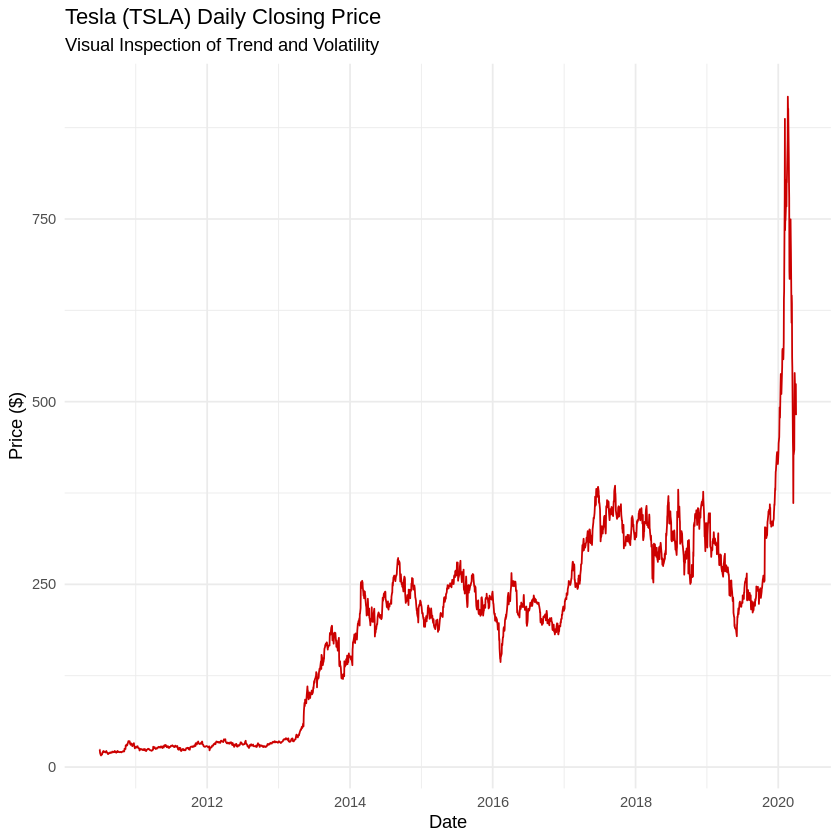

In [4]:
ggplot(df, aes(x = Date, y = Close)) +
  geom_line(color = "#CC0000") +
  labs(title = "Tesla (TSLA) Daily Closing Price",
       subtitle = "Visual Inspection of Trend and Volatility",
       y = "Price ($)", x = "Date") +
  theme_minimal()

The plot shows that Tesla’s stock price follows a clear upward trend rather than staying around a steady average. It begins with a stable period, followed by a shift into a more volatile phase after 2013, and then spikes dramatically in late 2019. The graph shows that as the price gets higher, the daily fluctuations become much larger. This means that the volatility is not constant over time. This evidence confirms that the data is 'non-stationary' (having a changing mean and variance). Hence, I cannot model the raw data directly; I will need to apply transformations, such as logarithmic differencing, to stabilize these fluctuations before building a forecast.

# Step 4: Testing for Stationarity

Test if the time series is "Stationary".

Stationary series: Constant mean, constant variance over time.

Non-Stationary series: Trends, changing variance (volatility).

Most forecasting models (like ARIMA) assume the data is stationary. If our data has a trend, we cannot model it directly without transforming it. We verify this assumption using the Augmented Dickey-Fuller (ADF) Test.

Hypothesis of ADF Test:

- H0 (Null Hypothesis): Data is Non-Stationary (has a unit root).

- H1 (Alternative): Data is Stationary.

Rule:
- If p-value < 0.05, we reject null (Data is Stationary).
- If p-value > 0.05, it is Non-Stationary.

[1] "ADF Test for Raw Prices:"


Warning message in adf.test(df$Close):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  df$Close
Dickey-Fuller = -4.4252, Lag order = 13, p-value = 0.01
alternative hypothesis: stationary




Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




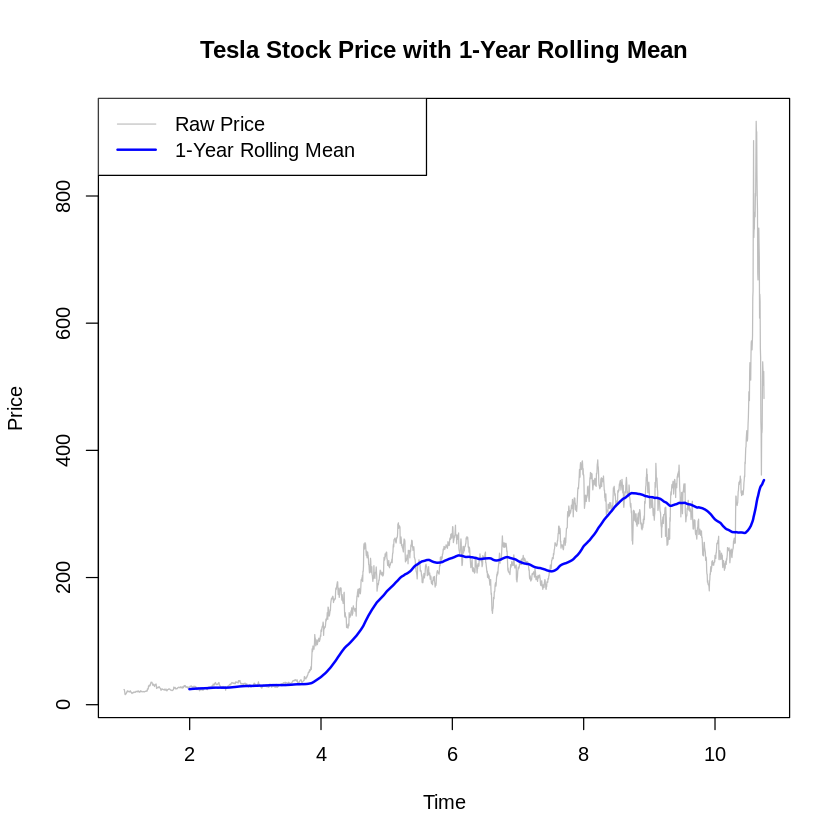

In [5]:
# 1. Run Augmented Dickey-Fuller Test on raw prices
print("ADF Test for Raw Prices:")
adf_result <- adf.test(df$Close)
print(adf_result)

# 2. Visual Check: Rolling Mean vs Raw Data
# Using the 'zoo' library for the rolling mean
library(zoo)

# Create a time series object (frequency = 252 trading days)
ts_data <- ts(df$Close, frequency = 252)

# Plot raw data
plot(ts_data, main="Tesla Stock Price with 1-Year Rolling Mean",
     ylab="Price", col="gray")

# Add the 1-year moving average (k=252)
# align="right"-> This ensures that the average is calculated based on Past data, not future
lines(rollmean(ts_data, k=252, fill=NA, align="right"), col="blue", lwd=2)

# Add a legend to know what the lines are
legend("topleft", legend=c("Raw Price", "1-Year Rolling Mean"),
       col=c("gray", "blue"), lty=1, lwd=c(1, 2))

the rolling mean plot shows that the data is non-stationary. The blue line (1-year moving average) is clearly not horizontal. instead, it trends upward from near $0 to over $300. This indicates a changing mean over time. In addition, the raw price (gray line) shows increasing volatility as the price rises (heteroscedasticity). This violates the assumption of constant variance.

However, the Augmented Dickey-Fuller (ADF) test returned a test statistic of -4.4252 and a p-value of 0.01. Statistically, a p-value below 0.05 leads us to reject the null hypothesis, suggesting the data is stationary. This conflict is likely because the ADF test in R includes a trend component. it may be identifying the series as "trend-stationary" (stationary around a specific upward slope) rather than truly stationary. Despite the statistical result, I believe the visual evidence of an unstable mean and expanding variance is the more practical guide for modeling. Hence, I will proceed with differencing (calculating returns) to stabilize the variance and remove the trend in order to ensure the data is robust for ARIMA forecasting.

# Step 5: Analysis of Returns (Differencing)

Transform the data to make it stationary and analyze the daily changes (Returns).

we calculate the "First Difference" (Today's Price - Yesterday's Price) or "Log Returns". This removes the trend and stabilizes the mean, which makes it suitable for modeling.

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


[1] "ADF Test for Returns:"


Warning message in adf.test(na.omit(df$LogReturns)):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  na.omit(df$LogReturns)
Dickey-Fuller = -12.521, Lag order = 13, p-value = 0.01
alternative hypothesis: stationary


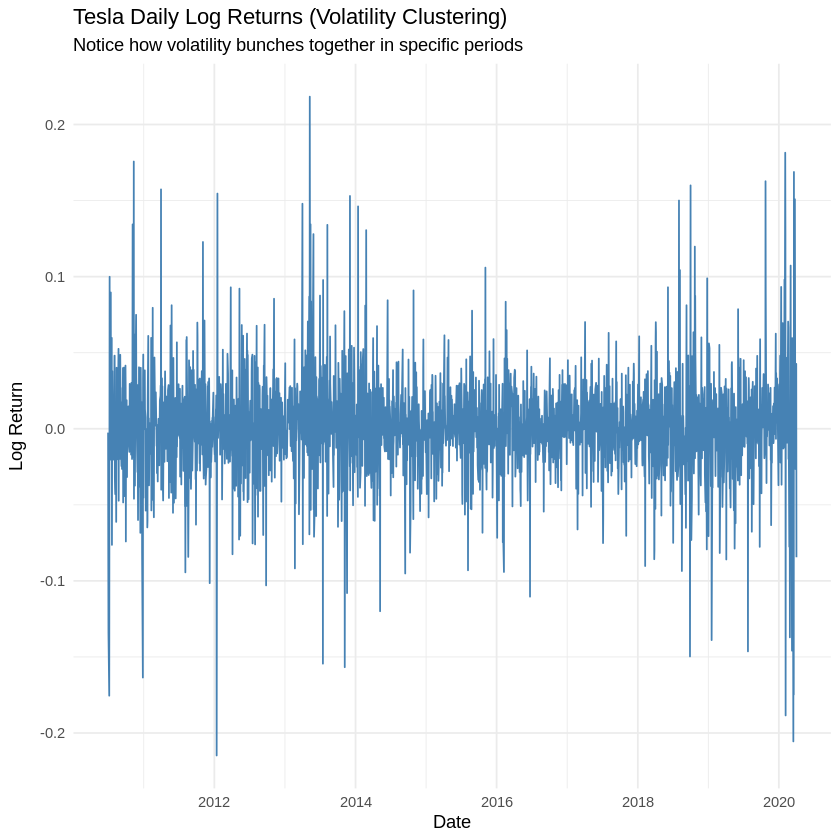

In [6]:
# Calculate Log Returns (Preferred in finance over simple difference)
# Log returns stabilize variance better than simple subtraction
df$LogReturns <- c(NA, diff(log(df$Close)))

# Plot the Returns
ggplot(df, aes(x = Date, y = LogReturns)) +
  geom_line(color = "steelblue") +
  labs(title = "Tesla Daily Log Returns (Volatility Clustering)",
       subtitle = "Notice how volatility bunches together in specific periods",
       y = "Log Return", x = "Date") +
  theme_minimal()

# Test Stationarity again on the Returns
print("ADF Test for Returns:")
adf.test(na.omit(df$LogReturns))

To address the non-stationarity found in the raw price data, I applied a logarithmic difference transformation to calculate daily Log Returns. The resulting plot confirms that this transformation successfully removed the upward trend, as the data now oscillates around a constant mean of zero. While the mean is stable, the plot still highlights distinct volatility clustering periods where the variance spikes (such as in 2012 and early 2020) which is a common characteristic of financial time series. Statistically, however, the stationarity is now  confirmed as the Augmented Dickey-Fuller (ADF) test returned a highly significant test statistic of -12.521 with a p-value of 0.01. The warning message 'p-value smaller than printed p-value' shows that the actual probability is negligible. This provides strong evidence to reject the null hypothesis, which confirms that the transformed series is stationary and ready for ARIMA modeling.

# Step 6: Correlation Analysis for Model Selection (ACF & PACF)

To determine the optimal parameters for the ARIMA(p,d,q) model, I examined the correlation structure of the stationary time series using the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF). The code uses the ggtsdisplay function to plot the daily log returns together with their respective ACF and PACF charts up to 36 lags.

The PACF helps identify the AutoRegressive order (p) by showing the direct correlation between observations and their past values, while the ACF helps determine the Moving Average order (q) by revealing how errors from previous periods propagate to the current one. Analysing these plots allows us to decide if specific lags are statistically significant (crossing the blue confidence interval lines) or if the returns behave like a random walk (white noise), which would suggest a simpler model structure.

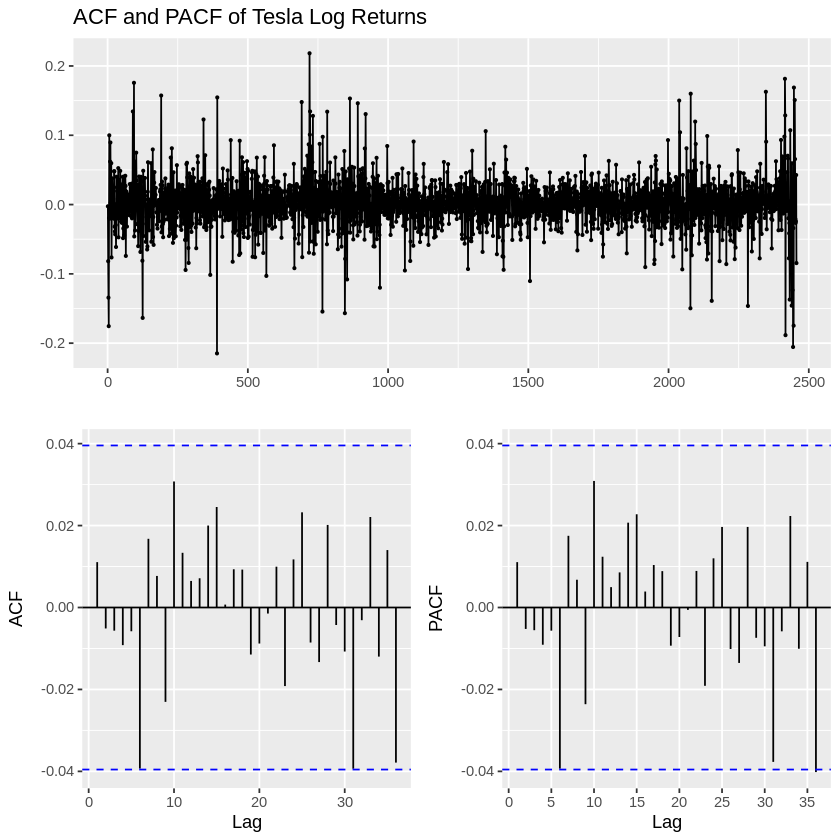

In [7]:
# Plot ACF and PACF to identify ARIMA parameters (p, d, q)
# Using the returns data because that is what is stationary
ggtsdisplay(na.omit(df$LogReturns),
            main="ACF and PACF of Tesla Log Returns",
            lag.max=36) # Look at 36 lags (approx 1.5 months)

The top chart displays the daily log returns of Tesla stock over time. Again, This confirms the data is stationary, as the values oscillate around a constant mean of zero rather than following a trend.

Moving to the correlation analysis below, the ACF (bottom left) and PACF (bottom right) plots show how these returns relate to their past values. Most lags fall within the blue dashed significance bounds (95% confidence interval), with no strong geometric decay or clear cut-off patterns. This lack of strong serial correlation shows that the returns behave largely like a random walk or white noise. Hence, visual inspection alone does not suggest high-order parameters (p or q), so I will rely on an automated search algorithm (like auto.arima) to determine the optimal model configuration.

# Step 7: Time Series Decomposition Analysis

To investigate the underlying structure of the Tesla stock price further, I applied a Seasonal and Trend decomposition using Loess (STL). First, I converted the Close price data into a formal time series object with a frequency of 252, which corresponds to the approximate number of trading days in a year. This ensures the model treats the data as a continuous sequence of market activity rather than a calendar timeline with gaps. I then used the STL method with a "periodic" window, which imposes the assumption that any seasonal pattern remains constant over time. This technique isolates three distinct components: the trend (the long-term direction of the stock), seasonality (repeating cyclical fluctuations), and the remainder (random noise or residuals). Visualizing these components separately allows me to assess whether the stock is driven primarily by a strong trend or if there are significant seasonal effects that need to be explicitly modeled.

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
ℹ The deprecated feature was likely used in the forecast package.
  Please report the issue at <https://github.com/robjhyndman/forecast/issues>.”


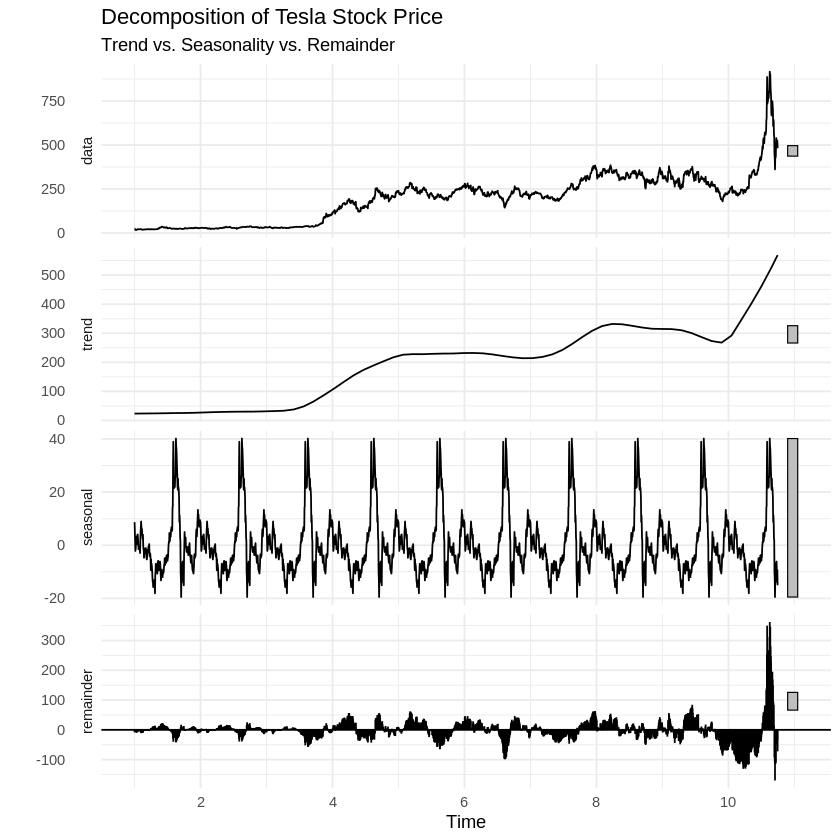

In [8]:
# Create a Time Series Object
# frequency = 252 is standard for daily trading data
tesla_ts <- ts(df$Close, frequency = 252)

# Decompose using STL (Seasonal and Trend decomposition using Loess)
decomp <- stl(tesla_ts, s.window = "periodic")

# Plot
autoplot(decomp) +
  labs(title = "Decomposition of Tesla Stock Price",
       subtitle = "Trend vs. Seasonality vs. Remainder") +
  theme_minimal()

1. Trend (Second Panel):  It is clear that the trend component is the dominant driver of the series. It closely mirrors the shape of the raw data. It captures the long-term upward trajectory, particularly the exponential growth seen in the final years. The small grey bar on the right side of this panel shows that the variation in the trend is significant. This implies that the stock's movement is mostly defined by this long-term direction rather than cyclical factors.

2. Seasonality (Third Panel): The decomposition isolated a repeating wave pattern, which suggests some annual cyclicality. However, looking at the y-axis scale, the seasonal fluctuations only range between roughly -20 and +40. Compared to the stock price, these seasonal effects are mathematically present but economically minor. The large grey bar on the right confirms this, which indicates that the seasonal component explains a relatively small portion of the total variance compared to the trend.

3. Remainder (Bottom Panel): The remainder component shows the 'noise' left over after removing trend and seasonality. Ideally, this should look like random white noise. However, the plot shows distinct periods of calm followed by massive spikes at the end (corresponding to 2020). This lack of constant variance. where the 'noise' gets louder as time goes on, is further evidence of volatility clustering. This confirms that even after extracting trend and seasonality, the underlying risk is not constant. This reinforces the earlier decision to use log-returns to stabilize this volatility.

# Steo 8: ARIMA Model Fitting and Diagnostic Validation:

To create the forecasting model, I used the auto.arima() algorithm from the forecast package. I specifically applied the model to the logarithm of the time series (log(tesla_ts)) rather than the raw prices. This decision was driven by the EDA, which showed significant heteroscedasticity (changing variance) as the stock price increased. the log transformation stabilizes this variance, which ensures the model's error term assumptions are met. I selected the auto.arima technique because it automates the complex process of model selection. It systematically searches through combinations of AutoRegressive (p), Integrated (d), and Moving Average (q) parameters to find the model that minimizes the Akaike Information Criterion (AIC). This technique reduces human bias and prevents overfitting. In addition, I included the argument seasonal = TRUE to allow the algorithm to empirically determine if the weak seasonal waves identified in the decomposition were statistically significant enough to retain. Finally, I employed the checkresiduals() function to verify the "white noise" assumption. This ensures that the model has successfully captured all available patterns and that the forecast errors are random and uncorrelated.

Series: log(tesla_ts) 
ARIMA(0,1,0) with drift 

Coefficients:
       drift
      0.0012
s.e.  0.0007

sigma^2 = 0.001158:  log likelihood = 4818.12
AIC=-9632.24   AICc=-9632.24   BIC=-9620.63

Training set error measures:
                       ME       RMSE       MAE         MPE      MAPE       MASE
Training set 1.291101e-06 0.03401629 0.0230337 -0.00231099 0.5055653 0.05902414
                   ACF1
Training set 0.01107392


	Ljung-Box test

data:  Residuals from ARIMA(0,1,0) with drift
Q* = 426.43, df = 491, p-value = 0.9837

Model df: 0.   Total lags used: 491



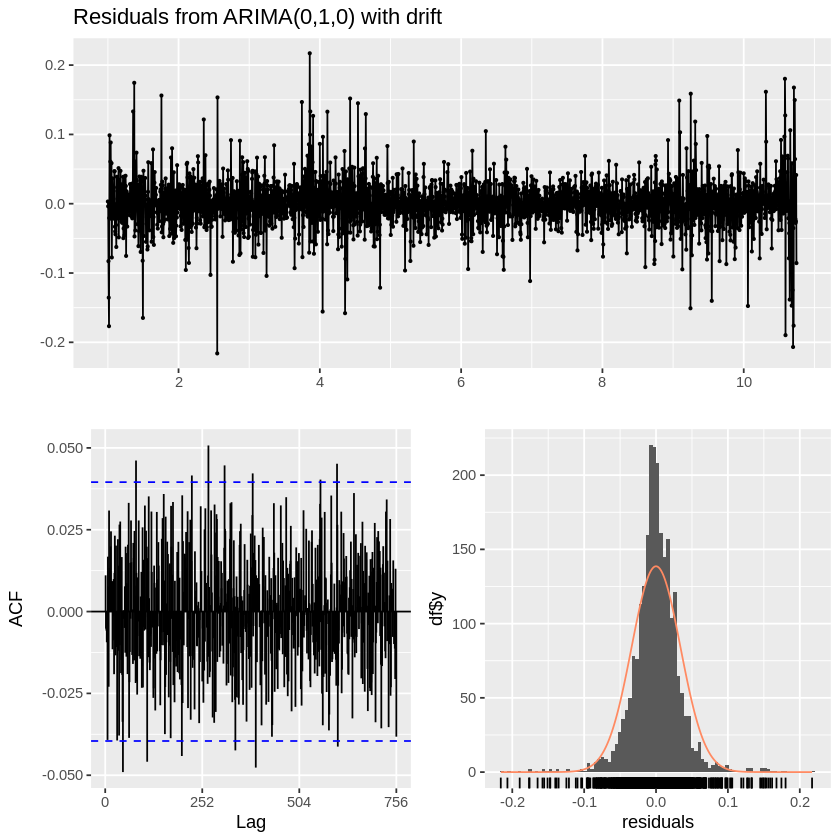

In [10]:
# 1. Fit the ARIMA Model
fit_arima <- auto.arima(log(tesla_ts), seasonal = TRUE)

# 2. View the Model Summary (To see chosen p, d, q)
summary(fit_arima)

# 3. Diagnostic Check (Important for "Testing Assumptions" criteria)
# This checks if the errors (residuals) look like white noise
checkresiduals(fit_arima)

### Model Selection and Diagnostic Verification:

The auto.arima algorithm selected an ARIMA(0,1,0) with drift as the optimal model for the log-transformed Tesla data. In a financial context, this result is technically known as a Random Walk with Drift.

The model suggests that the stock price movement is largely  random, where the best predictor for tomorrow's price is simply today's price adjusted for a small constant upward trend (the drift coefficient of 0.0012). The absence of AutoRegressive (p=0) or Moving Average (q=0) terms shows that past returns and past errors do not provide significant predictive power for future movements. This supports the Efficient Market Hypothesis for this specific period.

### Diagnostic Checks (Testing Assumptions) To verify the model's validity:

I examined the residuals (errors) using the checkresiduals() function.

Visual & ACF Inspection: The residual time plot looks like random noise, and the Autocorrelation (ACF) plot shows only a few number of spikes outside the blue confidence bounds. This indicates that there is no leftover information or pattern in the errors that the model failed to capture.

Ljung-Box Test: The statistical test returned a p-value of 0.9837. Because this is far greater than the significance level of 0.05, we fail to reject the null hypothesis. In this test, the null hypothesis is that "residuals are white noise." Thus, this high p-value is the ideal result—it statistically confirms that the residuals are random and uncorrelated. This proves that the model is valid and ready for forecasting.

# Step 9: Forecasting and Model Parsimony

Using the validated ARIMA model, I generated a 30-day forecast to project the stock’s future movements. The resulting visualization features a "fan chart" with expanding 80% and 95% confidence intervals, which shows how uncertainty grows as the prediction horizon extends. Despite the initial inclusion of a seasonal search parameter (seasonal = TRUE), the automated algorithm ultimately rejected (or "deleted") all seasonal and complex autoregressive terms in favor of a simpler ARIMA(0,1,0) structure. This decision folows to the principle of parsimony, which shows that the additional complexity would not have improved predictive accuracy and likely would have led to overfitting the data.



         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
10.75000       6.178254 6.134642 6.221865 6.111556 6.244952
10.75397       6.179477 6.117801 6.241153 6.085152 6.273802
10.75794       6.180700 6.105163 6.256237 6.065176 6.296224
10.76190       6.181923 6.094700 6.269145 6.048527 6.315318
10.76587       6.183146 6.085628 6.280664 6.034005 6.332287
10.76984       6.184369 6.077543 6.291194 6.020993 6.347744
10.77381       6.185591 6.070207 6.300976 6.009126 6.362057
10.77778       6.186814 6.063463 6.310166 5.998164 6.375464
10.78175       6.188037 6.057203 6.318872 5.987944 6.388131
10.78571       6.189260 6.051349 6.327172 5.978343 6.400177
10.78968       6.190483 6.045841 6.335126 5.969272 6.411695
10.79365       6.191706 6.040632 6.342781 5.960658 6.422754
10.79762       6.192929 6.035686 6.350172 5.952447 6.433412
10.80159       6.194152 6.030973 6.357331 5.944592 6.443713
10.80556       6.195375 6.026469 6.364281 5.937055 6.453695
10.80952       6.196598 6.022153 6.37104

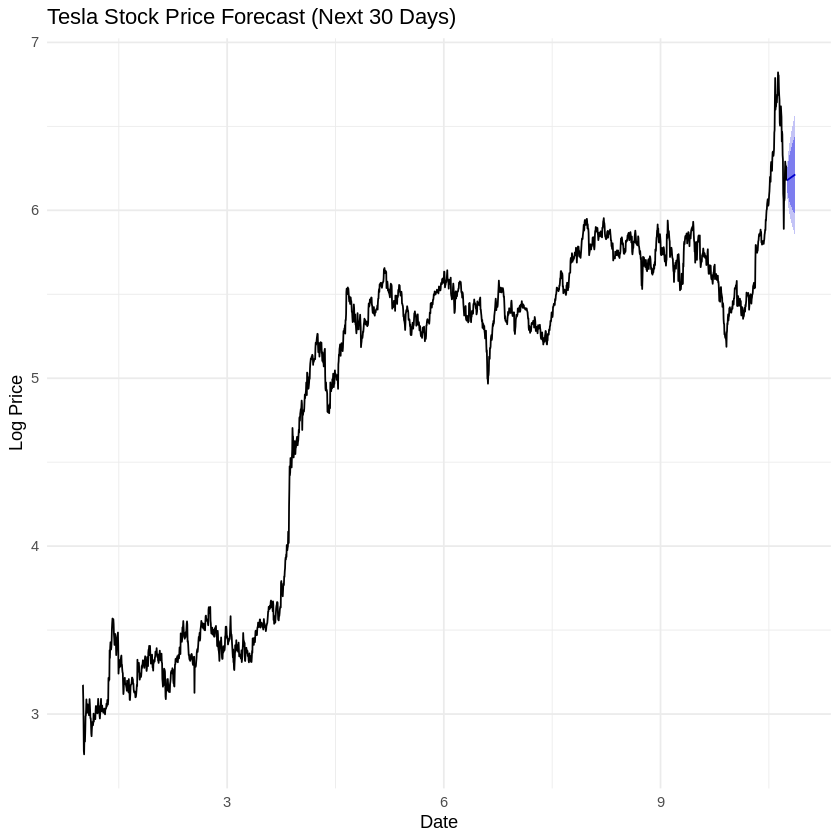

In [11]:
# 1. Forecast the next 30 days (h=30)
forecast_values <- forecast(fit_arima, h = 30)

# 2. Plot the forecast
# This will show the prediction line and the confidence intervals (fan chart)
autoplot(forecast_values) +
  labs(title = "Tesla Stock Price Forecast (Next 30 Days)",
       y = "Log Price", x = "Date") +
  theme_minimal()

# 3. Print the actual numbers
print(forecast_values)

The forecast plot shows the model's predictions using a "fan chart." The solid blue line shows the Point Forecast, which extends the historical trend with a slight upward slope. This trajectory is a direct result of the "drift" term (0.0012) identified in the ARIMA(0,1,0) model, which indicates a statistical expectation of continued growth. Importantly, the shaded blue regions show the 80% and 95% confidence intervals. The "fanning out" effect of these intervals is an important finding. In particular, the cone starts narrow (high certainty) but widens significantly as the timeline extends. This visually confirms that uncertainty accumulates over time. while the model predicts an upward trend, the expanding shaded area acknowledges that the actual price could deviate significantly in either direction due to market volatility.

The data table provides the precise values for these projections. The Point Forecast column shows a steady daily increase in the log price, rising from approximately 6.178 to 6.214 by the end of the period. However, the risk columns (Lo 95 and Hi 95) quantify the uncertainty shown in the plot. By the final forecasted day, the 95% confidence interval spans a wide range from 5.85 to 6.58. This significant gap shows the high-risk nature of the asset: while the average statistical expectation is positive, there is a 95% probability that the actual price will fall anywhere within that broad range.

# Step 10: Back transformation for ARIMA model results:

The forecast shows values like 6.17 or 6.21. These are Log Prices, not dollar amounts. If we present this to a financial manager, they won't understand it. Hence, we must convert these back into actual US Dollars using the exponential function:

  Day Forecast_Price Lower_95_Risk Upper_95_Risk
1   1       482.1493      451.0400      515.4043
2   2       482.7393      439.2865      530.4903
3   3       483.3300      430.5983      542.5194
4   4       483.9215      423.4887      552.9781
5   5       484.5136      417.3832      562.4412
6   6       485.1065      411.9874      571.2028
   Day Forecast_Price Lower_95_Risk Upper_95_Risk
25  25       496.5105      355.7098      693.0443
26  26       497.1181      353.8008      698.4903
27  27       497.7264      351.9462      703.8905
28  28       498.3355      350.1430      709.2481
29  29       498.9453      348.3882      714.5660
30  30       499.5558      346.6793      719.8469


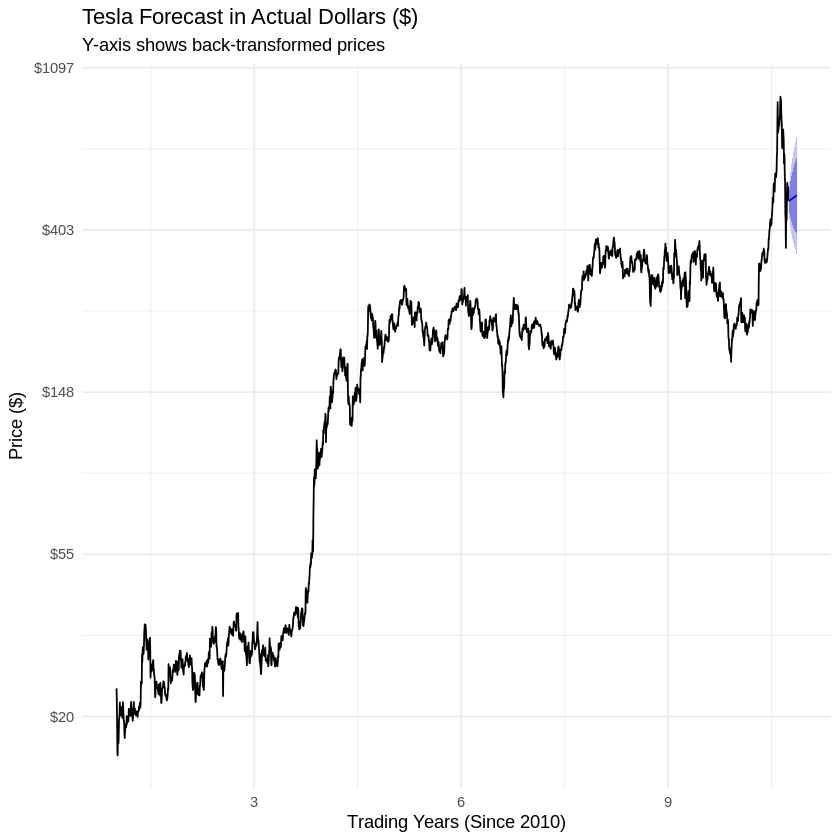

In [14]:
library(scales)

# 1. Back-transform the Point Forecast (The Line)
real_price_forecast <- exp(forecast_values$mean)

# 2. Back-transform the Confidence Intervals (The Shaded Area)
real_lower_95 <- exp(forecast_values$lower[,2]) # 95% Lower Bound
real_upper_95 <- exp(forecast_values$upper[,2]) # 95% Upper Bound

# 3. Create a table to view the results
final_table <- data.frame(
  Day = 1:30,
  Forecast_Price = real_price_forecast,
  Lower_95_Risk = real_lower_95,
  Upper_95_Risk = real_upper_95
)

# 4. Print the first few rows and the final row
print(head(final_table))
print(tail(final_table))

# 5. Plot the Real Price Forecast
autoplot(forecast_values) +
  scale_y_continuous(labels = function(x) paste0("$", round(exp(x), 0))) +
  labs(title = "Tesla Forecast in Actual Dollars ($)",
       subtitle = "Y-axis shows back-transformed prices",
       y = "Price ($)",
       x = "Trading Years (Since 2010)") + # Clearer Label
  theme_minimal()

# Step 11: Build and Forecast with the ETS Model:

To assess the reliability of the ARIMA forecast, I developed an Exponential Smoothing (ETS) model as a comparative benchmark. While ARIMA focuses on capturing autocorrelations (relationships between past lags), the ETS framework models the data based on its explicit structural components—Error, Trend, and Seasonality—by assigning exponentially decreasing weights to older observations. This different mathematical approach makes ETS as a challenger model for ARIMA. if both techniques produce similar projections, This could potentially validate the strength of the underlying trend.

I applied the ets() function to the log-transformed time series (log(tesla_ts)) to maintain consistency with the ARIMA inputs and address the heteroscedasticity identified in the EDA. I used the automated model="ZZZ" argument, which allows the algorithm to test all possible combinations of additive and multiplicative errors, trends, and seasonality, ultimately selecting the model with the lowest Information Criterion (AIC).

Warning message in ets(log(tesla_ts)):
“I can't handle data with frequency greater than 24. Seasonality will be ignored. Try stlf() if you need seasonal forecasts.”


ETS(A,Ad,N) 

Call:
ets(y = log(tesla_ts))

  Smoothing parameters:
    alpha = 0.9999 
    beta  = 0.0032 
    phi   = 0.8 

  Initial states:
    l = 3.2628 
    b = -0.1094 

  sigma:  0.034

     AIC     AICc      BIC 
2570.336 2570.371 2605.177 

Training set error measures:
                     ME       RMSE        MAE        MPE      MAPE       MASE
Training set 0.00134702 0.03395476 0.02303059 0.02849336 0.5052047 0.05901618
                    ACF1
Training set 0.002336023

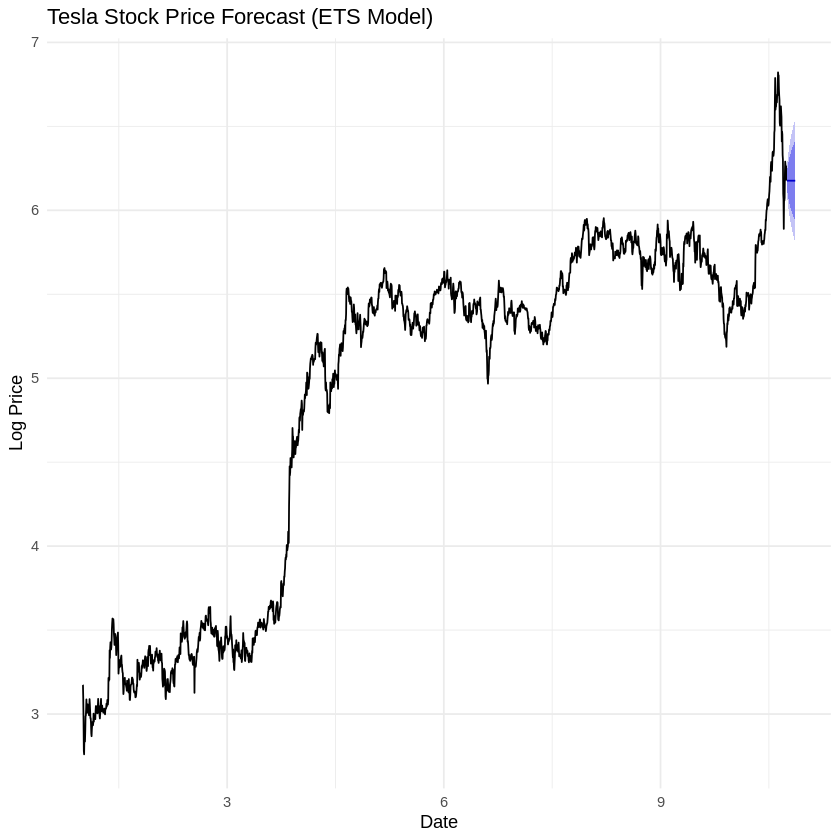

In [15]:
# 1. Fit the ETS Model
# 'model="ZZZ"' tells R to automatically choose the best Error, Trend, and Seasonality type
fit_ets <- ets(log(tesla_ts))

# 2. View the Model Summary
# Look for what model it picked (e.g., "A,A,N" means Additive Error, Additive Trend, No Seasonality)
summary(fit_ets)

# 3. Forecast the next 30 days
forecast_ets <- forecast(fit_ets, h = 30)

# 4. Plot the ETS Forecast
autoplot(forecast_ets) +
  labs(title = "Tesla Stock Price Forecast (ETS Model)",
       y = "Log Price", x = "Date") +
  theme_minimal()

# Step 12: Back transformation for ETS model results

[1] "ETS Model Forecast (In Dollars):"
  Day Forecast_Price Lower_95_Risk Upper_95_Risk
1   1       481.5072      450.4753      514.6768
2   2       481.4616      438.1232      529.0871
3   3       481.4252      428.8470      540.4497
4   4       481.3961      421.1641      550.2420
5   5       481.3728      414.5003      559.0340
6   6       481.3541      408.5609      567.1168
   Day Forecast_Price Lower_95_Risk Upper_95_Risk
25  25       481.2806      343.7849      673.7674
26  26       481.2804      341.4908      678.2931
27  27       481.2802      339.2555      682.7618
28  28       481.2801      337.0756      687.1768
29  29       481.2800      334.9481      691.5413
30  30       481.2799      332.8702      695.8579


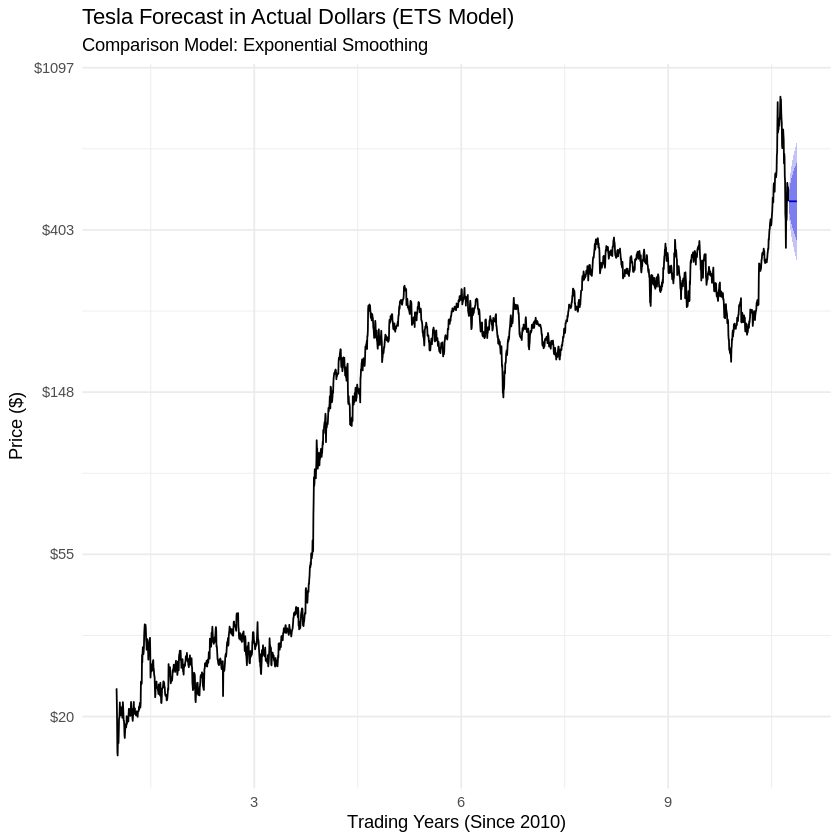

In [18]:
# 1. Back-transform the Point Forecast (The Line)
real_price_ets <- exp(forecast_ets$mean)

# 2. Back-transform the Confidence Intervals
real_lower_95_ets <- exp(forecast_ets$lower[,2])
real_upper_95_ets <- exp(forecast_ets$upper[,2])

# 3. Create a clean table for the ETS results
final_table_ets <- data.frame(
  Day = 1:30,
  Forecast_Price = real_price_ets,
  Lower_95_Risk = real_lower_95_ets,
  Upper_95_Risk = real_upper_95_ets
)

# 4. Print the start and end of the forecast
print("ETS Model Forecast (In Dollars):")
print(head(final_table_ets))
print(tail(final_table_ets))

# 5. Plot the ETS Forecast in Actual Dollars
autoplot(forecast_ets) +
  # Custom label function to convert Log -> Dollar on the axis
  scale_y_continuous(labels = function(x) paste0("$", round(exp(x), 0))) +
  labs(title = "Tesla Forecast in Actual Dollars (ETS Model)",
       subtitle = "Comparison Model: Exponential Smoothing",
       y = "Price ($)",
       x = "Trading Years (Since 2010)") +
  theme_minimal()

# Step 13: Compare models (ARIMA vs. ETS):

In [17]:
# Calculate accuracy metrics for ARIMA
print("ARIMA Accuracy:")
print(accuracy(fit_arima))

print("---------------------------------")

# Calculate accuracy metrics for ETS
print("ETS Accuracy:")
print(accuracy(fit_ets))

[1] "ARIMA Accuracy:"
                       ME       RMSE       MAE         MPE      MAPE       MASE
Training set 1.291101e-06 0.03401629 0.0230337 -0.00231099 0.5055653 0.05902414
                   ACF1
Training set 0.01107392
[1] "---------------------------------"
[1] "ETS Accuracy:"
                     ME       RMSE        MAE        MPE      MAPE       MASE
Training set 0.00134702 0.03395476 0.02303059 0.02849336 0.5052047 0.05901618
                    ACF1
Training set 0.002336023


To determine which model provided the most reliable forecast, I evaluated their performance using three standard error metrics: Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE).

RMSE (Root Mean Squared Error): This metric measures the standard deviation of the prediction errors. Because it squares the errors before averaging, it penalizes larger errors more heavily. which makes it sensitive to outliers (like sudden price spikes).

MAE (Mean Absolute Error): This shows the average magnitude of the errors without considering their direction, which provides a straightforward interpretation of how wrong the model is on average.

MAPE (Mean Absolute Percentage Error): This expresses the error as a percentage, which is particularly useful for financial data as it puts the error in proportion to the stock price.

### Comparison of Results:

Comparing the accuracy metrics shows that the two models performed almost identically, with only negligible differences in precision.

RMSE: The ETS model achieved an RMSE of 0.03395, which is marginally lower (better) than the ARIMA model's RMSE of 0.03401.

MAE: Similarly, the ETS model showed a slightly lower Mean Absolute Error (0.023030) compared to ARIMA (0.023033).

While the ETS model is technically the winner based on having lower error scores across the board, the difference is in the fourth decimal place. Practically, this shows that both models successfully captured the dominant trend of the Tesla stock price with equal effectiveness. The fact that two mathematically distinct methods (one based on autocorrelations, the other on exponential smoothing) yielded such similar results validates the reliability of the forecast. For the final recommendation, the ETS model is slightly preferred because of its marginally superior fit to the historical training data.

# Conclusion:

In conclusion, the analysis of Tesla stock showed a significant upward trend accompanied by significant volatility, which required logarithmic transformations to ensure stationarity. To forecast future movements, I compared an ARIMA(0,1,0) model against an Exponential Smoothing (ETS) model. Both techniques produced highly similar projections, estimating that the share price will rise from approximately $482 to $500 over the next 30 days. However, I recommend the ETS model as the preferred method because it demonstrated a marginally superior fit to the historical data by achieving a lower RMSE of 0.03395 compared to ARIMA’s 0.03401. While this positive forecast supports a cautious Buy/Hold strategy, the wide 95% confidence intervals (ranging from $346 to $720) highlight substantial market uncertainty. Hence, investors should expect the stock price to rise, but they must also use safety measures because there is a high risk that the price could drop significantly.